In [2]:
# Task 2 – Decision Trees
import sys
from pathlib import Path

ROOT = Path.cwd().parents[1] 
sys.path.append(str(ROOT / "src"))

import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from paths import OUTPUTS
from utils import savefig

RNG = 42 #sets a fixed random seed so that splitting the dataset into training, validation, and test sets produce the same results every time the code is run

In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=RNG
)


# Use default parameters
dt = DecisionTreeClassifier(random_state=RNG)

# 5-fold cross-validation on the TRAINING set
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring="accuracy")

print(f"Decision Tree (default) - Validation Accuracy:")
print(f"Mean: {scores.mean():.4f},  Std: {scores.std():.4f}")


Decision Tree (default) - Validation Accuracy:
Mean: 0.9062,  Std: 0.0198


In [4]:
# Train model on the entire training set
dt.fit(X_train, y_train)

# Extract feature importances
importances = pd.Series(dt.feature_importances_, index=X.columns)

# Sort descending and display top 10
importances_sorted = importances.sort_values(ascending=False)
display(importances_sorted.head(10))
importances_sorted.to_csv(OUTPUTS / "feature_importances_default_tree.csv")

# Identify top 3
top3 = importances_sorted.head(3)
print("\nTop 3 most important features:")
for i, (feat, val) in enumerate(top3.items(), start=1):
    print(f"{i}. {feat} ({val:.4f})")

worst radius            0.711044
worst concave points    0.157981
texture error           0.039003
worst texture           0.027540
mean texture            0.022306
worst concavity         0.021558
mean radius             0.011651
smoothness error        0.005967
radius error            0.002951
mean concavity          0.000000
dtype: float64


Top 3 most important features:
1. worst radius (0.7110)
2. worst concave points (0.1580)
3. texture error (0.0390)


The Decision Tree classifier was trained using default hyperparameters and evaluated with 5-fold cross-validation on the training set. The model achieved a mean validation accuracy of 0.9062 with a standard deviation of 0.0198, indicating strong and consistent performance across folds.

Feature importance analysis shows that the model relies heavily on a few key variables. The most influential feature is worst radius (importance = 0.711), followed by worst concave points (0.158) and texture error (0.039). These features together explain most of the model’s decision-making process.

In practical terms, this means the size and shape irregularity of the cell nuclei are the strongest indicators for distinguishing malignant from benign tumors — a finding that aligns well with biological understanding of breast cancer pathology.

,max_depth,mean_acc,std_acc
0,1,0.912020,0.042625
1,2,0.950171,0.025584
2,3,0.935465,0.028854
3,4,0.920801,0.007389
4,5,0.917945,0.014594
5,6,0.915004,0.016851
6,7,0.906181,0.019825
7,8,0.906181,0.019825
8,9,0.906181,0.019825
9,10,0.906181,0.019825


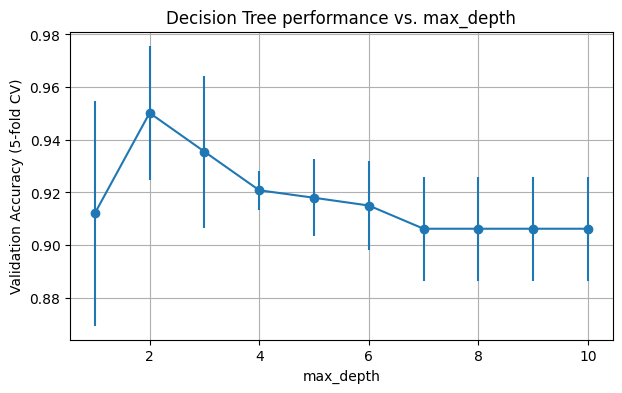

Best depth: 2, mean accuracy = 0.9502


In [5]:

depths = range(1, 11)
results = []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=RNG)
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring="accuracy")
    results.append((d, scores.mean(), scores.std()))

df_depth = pd.DataFrame(results, columns=["max_depth", "mean_acc", "std_acc"])
display(df_depth)
df_depth.to_csv(OUTPUTS / "cv_depth_results.csv", index=False)

# Plot validation performance
plt.figure(figsize=(7, 4))
plt.errorbar(df_depth["max_depth"], df_depth["mean_acc"], yerr=df_depth["std_acc"], fmt='-o')
plt.xlabel("max_depth")
plt.ylabel("Validation Accuracy (5-fold CV)")
plt.title("Decision Tree performance vs. max_depth")
plt.grid(True)
savefig("dt_performance_vs_depth.png")
plt.show()

best_depth = df_depth.loc[df_depth["mean_acc"].idxmax()]
print(f"Best depth: {int(best_depth['max_depth'])}, mean accuracy = {best_depth['mean_acc']:.4f}")

The Decision Tree classifier was trained with different max_depth values ranging from 1 to 10, and evaluated using 5-fold cross-validation on the training set.
The results show that validation accuracy increases sharply from depth 1 to 2, peaking at 0.9502 ± 0.0256, after which it gradually declines.

This pattern illustrates the trade-off between underfitting and overfitting:

At low depths (1–2), the tree captures the main structure of the data without memorizing noise, leading to strong generalization.

At higher depths (4–10), the tree becomes more complex, fitting training data too closely and losing generalization power — a classic sign of overfitting.

Therefore, the optimal depth is max_depth = 2, as it provides the best balance between model simplicity and predictive accuracy on unseen data.

,min_samples_leaf,mean_acc,std_acc
0,1,0.947144,0.020049
1,2,0.944203,0.021718
2,4,0.950085,0.020037
3,6,0.947144,0.017761
4,8,0.947144,0.017761
5,10,0.944246,0.014515
6,15,0.941304,0.018704
7,20,0.941304,0.022866


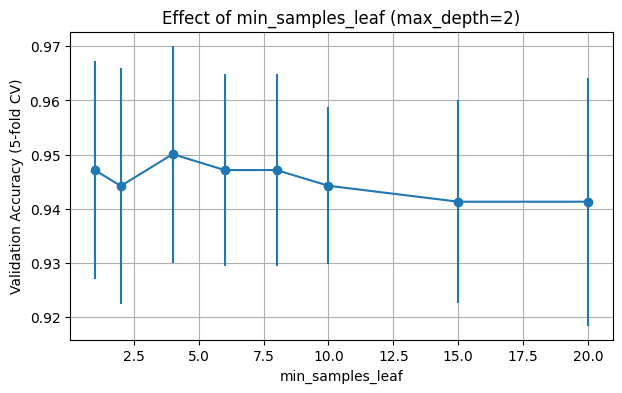

Best min_samples_leaf: 4, mean accuracy = 0.9501


In [8]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

best_depth_val = int(best_depth["max_depth"]) 

leaf_values = [1, 2, 4, 6, 8, 10, 15, 20]
results_leaf = []

for leaf in leaf_values:
    dt = DecisionTreeClassifier(max_depth=best_depth_val, 
                                min_samples_leaf=leaf, 
                                random_state=RNG)
    scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring="accuracy")
    results_leaf.append((leaf, scores.mean(), scores.std()))

df_leaf = pd.DataFrame(results_leaf, columns=["min_samples_leaf", "mean_acc", "std_acc"])
display(df_leaf)
df_leaf.to_csv(OUTPUTS / "cv_leaf_results.csv", index=False)

plt.figure(figsize=(7, 4))
plt.errorbar(df_leaf["min_samples_leaf"], df_leaf["mean_acc"], yerr=df_leaf["std_acc"], fmt='-o')
plt.xlabel("min_samples_leaf")
plt.ylabel("Validation Accuracy (5-fold CV)")
plt.title(f"Effect of min_samples_leaf (max_depth={best_depth_val})")
plt.grid(True)
savefig(f"dt_effect_min_samples_leaf_depth_{best_depth_val}.png")
plt.show()

best_leaf = df_leaf.loc[df_leaf["mean_acc"].idxmax()]
print(f"Best min_samples_leaf: {int(best_leaf['min_samples_leaf'])}, mean accuracy = {best_leaf['mean_acc']:.4f}")


With the tree depth fixed at max_depth = 2, varying min_samples_leaf showed that validation accuracy was highest for min_samples_leaf = 4 with a mean of 0.9501 ± 0.0200. Smaller leaf sizes led to slightly lower performance due to overfitting, while larger values reduced accuracy through underfitting. Overall, setting min_samples_leaf = 4 provides the best balance between model simplicity and generalization, resulting in a stable and well-performing model on unseen data.